In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.transforms as T

import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from jupyterplot import ProgressPlot
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim


In [28]:
#Import dataset
data = pd.read_csv("data/arpafvg_fllbandiera_clean.csv")

#Remove anno, mese, giorno columns
data = data.drop(columns = ["anno", "mese", "giorno"])

# Print 5 statistics of each feature
print(data.describe())


       Pioggia mm  Temp. min gradi C  Temp. med gradi C  Temp. max gradi C   
count  381.000000         381.000000         381.000000         381.000000  \
mean     3.309449          14.707874          17.228871          19.842520   
std      8.921197           6.251934           6.468947           6.755659   
min      0.000000           1.400000           3.100000           5.000000   
25%      0.000000           9.400000          11.500000          14.000000   
50%      0.000000          15.300000          18.100000          20.500000   
75%      1.600000          19.800000          22.500000          25.300000   
max     93.000000          27.600000          30.500000          35.000000   

       Umidita' min %  Umidita' med %  Umidita' max %  Vento med km/h   
count      381.000000      381.000000      381.000000      381.000000  \
mean        54.643045       68.860892       80.926509       12.356955   
std         14.740872       11.819434        9.835214        8.603465   
min  

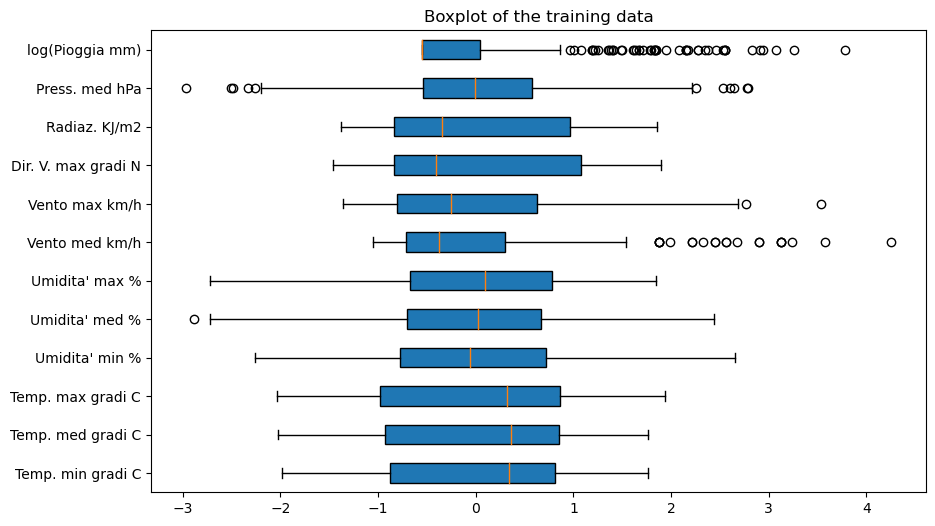

In [29]:
#Add the feature log(pioggiamm)
data["log(Pioggia mm)"] = np.log(data["Pioggia mm"] + 1)
#Drop the feature Pioggia mm
data = data.drop(columns = ["Pioggia mm"])

#Split the data 80% 20% do not shuffle
train_data = data.iloc[:int(len(data)*0.7)]
test_data = data.iloc[int(len(data)*0.9):]

#Normalize the data
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

# Boxplot of the training data
plt.figure(figsize=(10, 6))
plt.boxplot(train_data.values, vert=False, patch_artist=True)
plt.yticks(range(1, len(train_data.columns) + 1), train_data.columns)
plt.title("Boxplot of the training data")
plt.show()


In [30]:
def create_sequences(data, seq_length, target_column_index):
    xs, ys = [], []
    for i in range(len(data) - seq_length-1):
        x = data[i:i+seq_length]
        y = data[i+seq_length+1, target_column_index]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 7

train_x, train_y = create_sequences(train_data.values, SEQ_LENGTH, 0)
test_x, test_y = create_sequences(test_data.values, SEQ_LENGTH, 0)

# Convert the data to PyTorch tensors
X_train = torch.from_numpy(train_x).float()
y_train = torch.from_numpy(train_y).float()
X_test = torch.from_numpy(test_x).float()
y_test = torch.from_numpy(test_y).float()


In [31]:
class RainPredictorLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))
        
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = RainPredictorLSTM(input_size=X_train.shape[2], hidden_layer_size=4, output_size=1)

    


In [32]:
# Define train and test loaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=X_train.shape[0], shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=X_test.shape[0], shuffle=True)

In [39]:
# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []
test_losses = []

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        print(inputs.shape)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss/len(train_loader))

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = torch.zeros(inputs.shape[0])
            for i, (input, label) in enumerate(zip(inputs, labels)):
                outputs[i] = model(input)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)



torch.Size([258, 7, 12])


RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 84

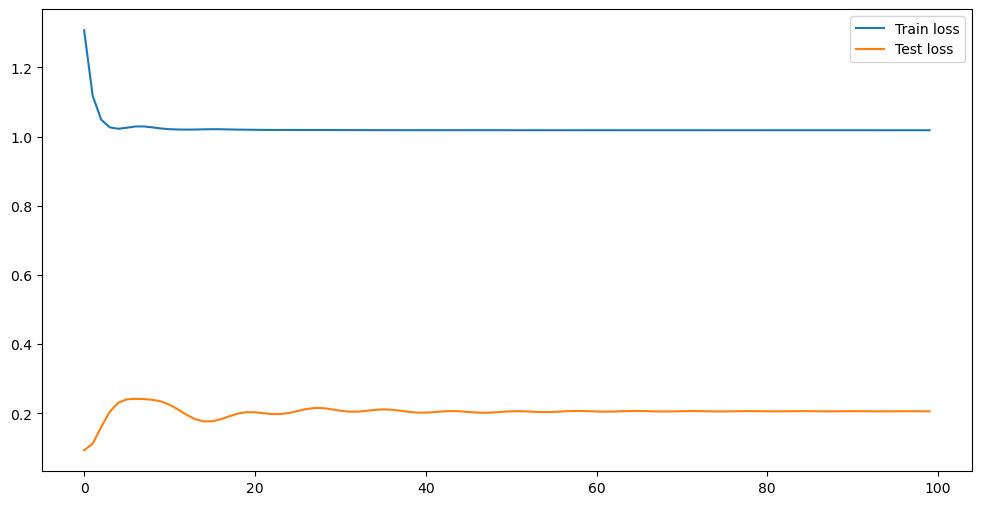

In [ ]:
# Plot the training and test losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()

/tmp/ipykernel_92031/3166588811.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_tensor = torch.tensor(data, dtype=torch.float32)


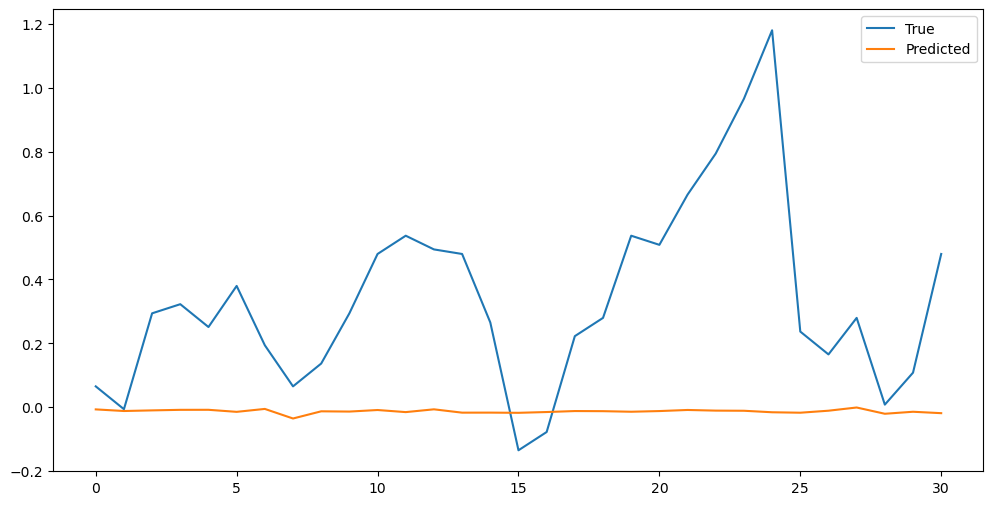

In [ ]:
def predict(model, data):
    model.eval()
    data_tensor = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        predictions = model(data_tensor)
    return predictions.numpy()

# Plot the data of the predicted rain vs the true rain
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True')
plt.plot(predict(model, X_test), label='Predicted')
plt.legend()
plt.show()

